In [1]:
from astropy.table import Table
import pandas as pd
import time
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astropy import units as u
from scipy.ndimage import gaussian_filter1d
import sys
from tqdm.notebook import tqdm
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic, FK4, FK5
from astropy import units as u
from astropy.wcs.utils import skycoord_to_pixel
from astropy.wcs import WCS
import warnings
warnings.filterwarnings("ignore")
import os
from IPython.display import Image

In [2]:
def get_narrwband(wave, lo=6563,dw=10.0,sig=1.0,alpha=1): 
    y1=(1+np.exp(-((wave-(lo-dw/2))/sig)))**(-alpha)
    y2=(1+np.exp(((wave-(lo+dw/2))/sig)))**(-alpha) 
    y=y1*y2
    return y

In [3]:
def simpson_r(f,x,i1,i2,typ=0):
    n=(i2-i1)*1.0
    if n % 2:
        n=n+1.0
        i2=i2+1
    b=x[i2]
    a=x[i1]
    h=(b-a)/n
    s= f[i1]+f[i2]
    n=int(n)
    dx=b-a
    for i in range(1, n, 2):
        s += 4 * f[i1+i]
    for i in range(2, n-1, 2):
        s += 2 * f[i1+i]
    if typ == 0:
        return s*h/3.0
    if typ == 1:
        return s*h/3.0/dx

In [4]:
def band_cube(name, dir='', dir1='',valTs=[[7,15],[7,13.5],[7,15.5]]):
    vel_light=299792458.0
    ang=1e-10
    jans=1e-23
    [pdl_flux,hdr]=fits.getdata(dir1+name, 0, header=True)
    pdl_flux=pdl_flux#*1e-16
    [nw,nx,ny]=pdl_flux.shape
    crpix=hdr["CRPIX3"]
    cdelt=hdr["CDELT3"]
    crval=hdr["CRVAL3"]
    int_spec1=np.zeros(nw)
    int_spec2=np.zeros(nw)
    wave_s=np.zeros(nw)
    for j in range(0, nw):
        wave_s[j]=(crval+cdelt*(j+1-crpix))#/ang
        int_spec1[j]=np.nansum(pdl_flux[j,:,:])
        int_spec2[j]=np.nansum(pdl_flux[j,:,:])*wave_s[j]**2.0/cdelt/vel_light*ang
    file=['LICK_LICK.3734_63.dat','LaSilla_DFOSCOIII_filter.dat','LICK_LICK.6563_100.dat','LICK_LICK.6710_100.dat','SLOAN_SDSS.g.dat','SLOAN_SDSS.r.dat','SLOAN_SDSS.i.dat']
    band=['OII','OIII','HI','SII','g','r','i']
    zerop=[3631.0,3730.0,3730.0,3631.0,3631.0,3631.0,3631.0]
    for k in range(0, len(band)):
        photo_a=np.zeros([nx,ny])
        photo_b=np.zeros([nx,ny])
        photo_c=np.zeros([nx,ny])
        f=open(dir+file[k],'r')
        wave=[]
        trans=[]
        for line in f:
            data=line.replace('/n','').split(' ')
            data=list(filter(None,data))
            if len(data) > 1:
                wave.extend([float(data[0])])
                trans.extend([float(data[1])])
        f.close()
        d_wave=np.zeros(len(wave))
        for kk in range(1,len(wave)):
            d_wave[kk]=wave[kk]-wave[kk-1]
        d_wave[0]=d_wave[1]
        trans=np.array(trans)
        wave=np.array(wave)
        if 'OII' == band[k]:
            trans=get_narrwband(wave, lo=3729,dw=5)
        if 'OIII' == band[k]:
            trans=get_narrwband(wave, lo=5007,dw=5) 
        if 'HI' == band[k]:
            trans=get_narrwband(wave, lo=6564,dw=5) 
        if 'SII' == band[k]:
            trans=get_narrwband(wave, lo=6732,dw=5)    
        for i in range(0, nx):
            for j in range(0, ny):
                spec=pdl_flux[:,i,j]
                if np.nansum(spec) != 0:
                    spec1=interp1d(wave_s, spec,kind='linear',bounds_error=False,fill_value=0.)(wave)
                    flux_t=spec1*trans*d_wave
                    f_fin=simpson_r(flux_t*wave**2.0/d_wave/vel_light*ang,wave,0,len(wave)-2,typ=1)/simpson_r(trans,wave,0,len(wave)-2,typ=1)/jans/zerop[k]
                    f_fi2=simpson_r(flux_t/d_wave,wave,0,len(wave)-2,typ=0)#/simpson_r(trans,wave,0,len(wave)-2,typ=1)
                    if f_fin <= 0:
                        photo_a[i,j]=-2.5*np.log10(1e-10)#14
                    else:
                        photo_a[i,j]=-2.5*np.log10(f_fin)
                    photo_b[i,j]=f_fin*zerop[k]*jans
                    photo_c[i,j]=f_fi2
        if k == 0:
            hdr["NAXIS"]=2
            hdr["UNITS"]=('Magnitudes', '-2.5log(F/F0) with F0 as ZPOINT')
            del hdr["NAXIS3"]
            del hdr["CRPIX3"]
            del hdr["CDELT3"]
            del hdr["CRVAL3"]
            del hdr["CUNIT3"]
            del hdr["CTYPE3"]
            del hdr["EXTNAME"]
        hdr["PBAND"]=band[k]
        hdr["ZPOINT"]=(zerop[k], 'Zero Point in Jy')
        hdr2=hdr
        hdr3=hdr
        if k == 0:
            hdr2["UNITS"]='ergs/s/cm^2/Hz'
            hdr3["UNITS"]='ergs/s/cm^2/A'
        dv=2
        #PSF=Gaussian2DKernel(stddev=dv)
        imag_F1=photo_a#convolve(photo_a, PSF)#, mode='full')#,  boundary='symm')#photo_a#
        imag_F2=photo_b#convolve(photo_b, PSF)#photo_b#
        imag_F3=photo_c#convolve(photo_c, PSF)#photo_c#
        name_f=name.replace('.fits.gz','.')
        fits.writeto(dir1+name_f+band[k]+'.fits',imag_F1,hdr,overwrite=True)
        fits.writeto(dir1+name_f+band[k]+'_F.fits',imag_F2,hdr2,overwrite=True)
        fits.writeto(dir1+name_f+band[k]+'_L.fits',imag_F3,hdr3,overwrite=True)
    name_f=name.replace('.fits.gz','.')
    from PIL import Image
    fileg=dir1+name_f+"g.fits"
    filer=dir1+name_f+"r.fits"
    filei=dir1+name_f+"i.fits"
    fileOIII=dir1+name_f+"OIII.fits"
    fileHI=dir1+name_f+"HI.fits"
    fileSII=dir1+name_f+"SII.fits"
    [pdl_g,hdrt]=fits.getdata(fileg, 0, header=True)
    [pdl_r,hdrt]=fits.getdata(filer, 0, header=True)
    [pdl_i,hdrt]=fits.getdata(filei, 0, header=True)
    [pdl_OIII,hdrt]=fits.getdata(fileOIII, 0, header=True)
    [pdl_HI,hdrt]=fits.getdata(fileHI, 0, header=True)
    [pdl_SII,hdrt]=fits.getdata(fileSII, 0, header=True)
    max=10.0#np.amin(pdl_r[np.where(pdl_r > 0)])-0.5#24.0#17.5
    min=15.6
    min1=valTs[2][1]
    min2=valTs[1][1]
    min3=valTs[0][1]
    max1=valTs[2][0]
    max2=valTs[1][0]
    max3=valTs[0][0]
    #min1=15.6
    #min1=17
    #min2=15.6
    #min2=17
    #min3=16.6
    #min3=17
    #max1=13
    #max1=11
    #max2=11
    #max2=8
    #max3=10
    #max3=11
    nx,ny=pdl_g.shape
    pdl_g=(np.flipud(pdl_g)-min)/(max-min)*256
    pdl_r=(np.flipud(pdl_r)-min)/(max-min)*256
    pdl_i=(np.flipud(pdl_i)-min)/(max-min)*256
    pdl_OIII=(np.flipud(pdl_OIII)-min1)/(max1-min1)*256
    pdl_HI=(np.flipud(pdl_HI)-min2)/(max2-min2)*256
    pdl_SII=(np.flipud(pdl_SII)-min3)/(max3-min3)*256
    pdl_g[np.where(pdl_g < 0)]=0
    pdl_r[np.where(pdl_r < 0)]=0
    pdl_i[np.where(pdl_i < 0)]=0
    pdl_OIII[np.where(pdl_OIII < 0)]=0
    pdl_HI[np.where(pdl_HI < 0)]=0
    pdl_SII[np.where(pdl_SII < 0)]=0
    pdl_g[np.where(pdl_g > 255)]=255
    pdl_r[np.where(pdl_r > 255)]=255
    pdl_i[np.where(pdl_i > 255)]=255
    pdl_OIII[np.where(pdl_OIII > 255)]=255
    pdl_HI[np.where(pdl_HI > 255)]=255
    pdl_SII[np.where(pdl_SII > 255)]=255
    pdl_00=np.zeros([nx,ny,3],dtype="uint8")
    pdl_00[:,:,0]=pdl_i
    pdl_00[:,:,1]=pdl_r
    pdl_00[:,:,2]=pdl_g
    im = Image.fromarray(pdl_00)
    im.save(dir1+name_f+"gri.jpeg",quality=100)
    pdl_00[:,:,0]=pdl_SII
    pdl_00[:,:,1]=pdl_HI
    pdl_00[:,:,2]=pdl_OIII
    im1 = Image.fromarray(pdl_00)
    im1.save(dir1+name_f+"OHS.jpeg",quality=100)
    #pdl_00[:,:,0]=pdl_SII
    #pdl_00[:,:,1]=pdl_HI
    #pdl_00[:,:,2]=pdl_OIII
    #im1 = Image.fromarray(pdl_00)
    #im1.save(dir1+name_f+"OHS.jpeg",quality=100)

In [20]:
path_lvmcore=os.environ['LVMCORE_DIR']
path_sas=os.environ['SAS_BASE_DIR']



valTs=[[10,16.6],[11,15.6],[13,15.6]]
mjd='60235'#'60222'
expn='00006817'#'00006115'
valTs=[[11,17],[8,17],[11,17]]
mjd='60231'
expn='00006639'
#valTs=[[7,15],[7,13.5],[7,15.5]]
#expn='00006843'
#mjd='60236'
redux_dir=path_sas+'/sdsswork/lvm/spectro/redux'
redux_ver='0.1.1.dev0/1111'
basenameC='lvmCube-NAME.fits.gz'

name=basenameC.replace('NAME',expn)
band_cube(name,dir1=redux_dir+'/'+redux_ver+'/'+mjd+'/',valTs=valTs)

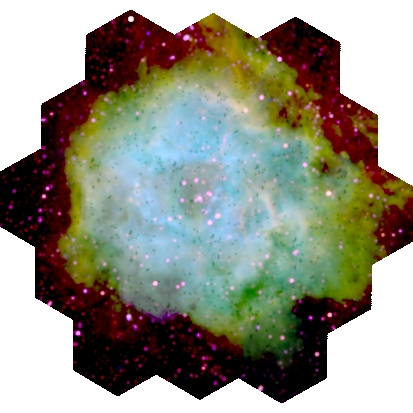

In [21]:
Image(filename=redux_dir+'/'+redux_ver+'/'+mjd+'/'+basenameC.replace('NAME',expn).replace('.fits.gz','.OHS.jpeg'))  

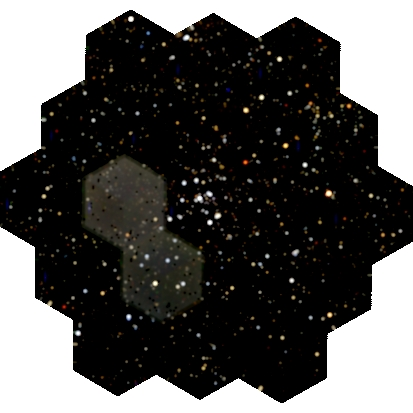

In [17]:
Image(filename=redux_dir+'/'+redux_ver+'/'+mjd+'/'+basenameC.replace('NAME',expn).replace('.fits.gz','.gri.jpeg'))